In [4]:
from boututils.datafile import DataFile
from boutdata.collect import collect
from boutdata.data import BoutData
import os, sys
import matplotlib
# matplotlib.use('Qt5Agg',force=True)
# matplotlib.use("TKAgg",force=True)
# matplotlib.use("widget",force=True)
import matplotlib.pyplot as plt
import xbout
import pandas as pd
import numpy as np
import pickle as pkl
import xarray as xr

from boutdata.restart import addvar
import glob
import shutil

import scipy
import regex as re

sys.path.append(r"/ssd_scratch/scripts/sdtools")


from hermes3.case_db import *
from hermes3.load import *
from hermes3.named_selections import *
from hermes3.neutral_transport import NeutralTransport
from hermes3.plotting import *
from hermes3.grid_fields import *
from hermes3.accessors import *
from hermes3.utils import *
# from code_comparison.code_comparison import *


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# IO

In [2]:
cs = dict()

db = CaseDB(
    case_dir = r"/ssd_scratch/hcases",
    grid_dir = r"/ssd_scratch/hcases"
    )

toload = [ 
    # dict(name="example", id="1D-recycling-cvode", guard_replace = False, unnormalise = False),  
    # dict(name="test", id="bl1b-test", guard_replace = False, unnormalise = True),  
    dict(name="step_loar", id="spr45_nD_fimp-0-0_udens-1-86e20_redist", guard_replace = False, unnormalise = True), 
    # dict(name="step_hiar", id="spr45_nD_linPow_3x_fimp-6-0-2-3_redist", guard_replace = False, unnormalise = True),  

]

for case in toload:
    cs[case["name"]] = Load.case_1D(db.casepaths[case["id"]], guard_replace = case["guard_replace"], unnormalise = case["unnormalise"])


/ssd_scratch/scripts/.venv/lib/python3.11/site-packages/xarray/core/concat.py:527: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


Skipping unnormalisation


# Balances function

In [5]:
ds.dims

Frozen({'pos': 420})

In [6]:
# def calculate_1d_balances(ds, unnormalised = True):
ds = cs["step_loar"].ds

unnormalised = True

if unnormalised is True:
    mp = constants("mass_p")
    me = constants("mass_e")
    qe = constants("q_e")
else:
    mp = 1
    me = 1
    qe = 1

gamma_e = ds.options["sheath_boundary_simple"]["gamma_e"]
gamma_i = ds.options["sheath_boundary_simple"]["gamma_i"]




calculate_1d_balances(ds)


***Warning, species choice currently hardcoded



NameError: name 're' is not defined

In [29]:
for param in pbal:
    print(param)

NameError: name 'pbal' is not defined

In [10]:

def calculate_1d_heat_balance(ds):
    last = ds.isel(pos = -2)
    dom = ds.isel(pos = slice(2,-2))
    
    sheath_flux_candidates = [var for var in ds.data_vars if re.search("S.*\+_sheath", var)]
    if len(sheath_flux_candidates) == 0:
        raise ValueError("No sheath particle flux diagnostics found, check if Hermes-3 is saving it")

    def integral(data):
        return (data * dom["dv"]).sum("pos").values

    hfe_sheath = (dom["Ee_sheath"] * dom["dv"]).sum("pos")
    hfi_sheath = (dom["Ed+_sheath"] * dom["dv"]).sum("pos")
    hf_riz = (dom["Rd+_ex"] * dom["dv"]).sum("pos")
    hf_rec = (dom["Rd+_rec"] * dom["dv"]).sum("pos")
    hf_recycle = (dom["Ed_target_recycle"] * dom["dv"]).sum("pos")
        
        

    df = pd.DataFrame(columns = ["value"])
    df.loc["Src"] = ((dom["Pd+_src"] + dom["Pe_src"] + dom["Pd_src"]) * (3/2) * dom["dv"]).sum("pos").values
    df.loc["Riz"] = hf_riz.values
    df.loc["Rrec"] = hf_rec.values
    df.loc["Rar"] = -1 * (dom["Rar"] * dom["dv"]).sum("pos").values
    df.loc["Recycle"] = hf_recycle.values
    df.loc["Sheath_e"] = hfe_sheath.values
    df.loc["Sheath_i"] = hfi_sheath.values
    df.loc["Sources sum"] = df.loc[["Src", "Riz", "Rar", "Rrec", "Recycle"]].sum()   # Should be zero
    df.loc["Sheath"] = hfe_sheath.values + hfi_sheath.values
    df.loc["Error: (Sources sum + sheath)/Src"] = (df.loc["Sources sum"] + df.loc["Sheath"]) / df.loc["Src"]

# df.loc["Error"] = (df.loc["Recycle"] + df.loc["Outflow"]) / df.loc["Recycle"]
df

# fig, ax = plt.subplots()

# pf_iz.plot(label = "iz")
# pf_recycle.plot(label = "recycle")
# ds["pfd+_sheath"].plot(label = "ions out")

# ax.legend()


array(3.19034116e+26)

# Reconstruction & balance

## Functions

# WARNING THIS MUST BE CORRECT

In [3]:
unnormalise = toload[0]["unnormalise"]

In [4]:
ds  = cs["step_loar"].ds
if "t" in ds.dims: ds = ds.isel(t=-1)


if unnormalise is True:
    mp = constants("mass_p")
    me = constants("mass_e")
    qe = constants("q_e")
else:
    mp = 1
    me = 1
    qe = 1

gamma_e = ds.options["sheath_boundary_simple"]["gamma_e"]
gamma_i = ds.options["sheath_boundary_simple"]["gamma_i"]

def limitFree(fm, fc):
    #  Limited free gradient of log of a quantity
    #  This ensures that the guard cell values remain positive
    #  while also ensuring that the quantity never increases
    # 
    #   fm  fc | fp
    #          ^ boundary
    # 
    #  exp( 2*log(fc) - log(fm) )
    # 

    if fm < fc:
        return  fc    # Neumann
        
    if fm < 1e-10:
        return fc
    
    return  (fc**2 / fm).values

# LIMITFREE WAS WRONG INITIALLY - I RETROACTIVELY FIXED IT BUT DIDNT RERUN NOTEBOOK

## Guard cell / sheath

In [5]:
previous = ds.isel(pos=-4)
last = ds.isel(pos=-3)
guard = ds.isel(pos=-2)
dom = ds.isel(pos = slice(2,-2))   # Domain

ne_guard = limitFree(previous["Ne"], last["Ne"])
ti_guard = limitFree(previous["Td+"], last["Td+"])
te_guard = limitFree(previous["Te"], last["Te"])
pi_guard = limitFree(previous["Pd+"], last["Pd+"])

print(f"Ni_guard = {ne_guard:.4e}")
print(f"Ti_guard = {ti_guard:.4e}")
print(f"Pi_guard = {pi_guard:.4e}")


def get_sheath(param):
    return ((last[param] + guard[param]) / 2).values

tesheath = get_sheath("Te")
tisheath = get_sheath("Td+")
visheath = get_sheath("Vd+")
nisheath = get_sheath("Nd+")
nesheath = get_sheath("Ne")
nvisheath = get_sheath("NVd+")
dasheath = get_sheath("da")
dvsheath = get_sheath("dv")

sheath_ion_polytropic = 1
Zi = 1
AA = 2
Mi = mp * AA

cisqsheath =  (sheath_ion_polytropic * tisheath + Zi * tesheath) / Mi

NVi_guard_calc = 2 * AA * nisheath * visheath - last["NVd+"].values


print(f"visheath = {visheath:.4e}")
print(f"nisheath = {nisheath:.4e}")
print(f"Vi_guard = {guard['Vd+']:.4e}")
print(f"nvisheath = {nvisheath:.4e}")
print(f"cisqsheath = {cisqsheath:.4e}")
print(f"NVi_guard_code = {guard['NVd+']:.4e}")
print(f"NVi_guard_calc = {NVi_guard_calc:.4e}")

Ni_guard = 6.7227e+13
Ti_guard = 7.7320e-01
Pi_guard = 8.3282e-06
visheath = 1.0152e+04
nisheath = 2.2185e+14
Vi_guard = 2.0189e+04
nvisheath = 0.0000e+00
cisqsheath = 6.4332e+26
NVi_guard_code = -1.4637e-10
NVi_guard_calc = 9.0092e+18


In [6]:
dasheath2 =  last["dx"] * last["dz"] * (last["J"] + guard["J"]) / (np.sqrt(last["g_22"]) + np.sqrt(guard["g_22"]))

print(f"dasheath = {dasheath:.4e}")
print(f"dasheath2 = {dasheath2:.4e}")

dasheath = 2.0444e+00
dasheath2 = 2.0444e+00


- Ni_guard, Ti_guard, Pi_guard are correct
- Visheath is correct
- cisqsheath is correct

## Reconstructing PF 

In [7]:
Si_sheath = np.zeros_like(ds["Ne"].values)

ds["Sd+_sheath2"] = xr.DataArray(np.zeros_like(ds["Ne"].values), dims = ds["Ne"].dims, coords = ds["Ne"].coords, attrs = ds["Ne"].attrs)
ds["Sd+_sheath2"][dict(pos=-3)] = (visheath * nesheath * dasheath / last["dv"]).values * -1
ds["Sd+_sheath2"].attrs.update(standard_name = "particle source", conversion = 1, units = "m^-3 s^-1", source = "xHermes", long_name = "sheath particle source")

print("Sd+_sheath =", ds["Sd+_sheath"].isel(pos = -3).values)
print("Sd+_sheath2 =", ds["Sd+_sheath2"].isel(pos = -3).values)

Sd+_sheath = -1.3004250391221345e+20
Sd+_sheath2 = -1.300425039122135e+20


# Particle balance

In [8]:
df = pd.DataFrame(columns = ["value"])
df.loc["Src"] = (dom["Sd+_src"] * dom["dv"]).sum("pos").values
df.loc["PI"] = (dom["Sd+_feedback"] * dom["dv"]).sum("pos").values
df.loc["IZ"] = (dom["Sd+_iz"] * dom["dv"]).sum("pos").values
df.loc["REC"] = (dom["Sd+_rec"] * dom["dv"]).sum("pos").values
df.loc["Recycle"] = (dom["Sd_target_recycle"] * dom["dv"]).sum("pos").values
df.loc["Sheath"] = (dom["Sd+_sheath"] * dom["dv"]).sum("pos").values
df.loc["Net sources"] = (df.loc[["Src", "PI", "IZ", "REC"]]).sum() 
df.loc["Net sheath"] = (df.loc[["Recycle", "Sheath"]]).sum()

df


,value
Src,0.000000e+00
PI,1.156510e+23
IZ,3.190341e+26
REC,-3.836461e+26
Recycle,4.604678e+18
Sheath,-4.604678e+18
Net sources,-6.449630e+25
Net sheath,0.000000e+00


Ni_guard = 0.613505
Ti_guard = 0.849143
Pi_guard = 0.520954

# Energy balance

In [9]:
qe

1.60217662e-19

In [10]:
# Ion flow speed
cisheath = cisqsheath**2

# Parallel heat flux in W/m^2.
# Note: Corrected for 5/2Pe convective thermal flux, and small electron kinetic energy flux
# so gamma_e is the total *energy* flux coefficient.

phi_wall = 0
vesheath = visheath   # Only valid without currents
q_e = gamma_e * qe * tesheath * nesheath * vesheath
q_i = gamma_i * qe * tisheath * nesheath * visheath

# hfi_sheath = last["Ed+_sheath"]
# hfi_sheath2 = q_i * dasheath / last["dv"]

# hfe_sheath = last["Ee_sheath"]
hflux_e = -q_e * dasheath / last["dv"]

# ds["hfe_sheath"] = hfe
# ds["hfd+_sheath"] = hfi

# ds["hfe_sheath"].attrs.update(standard_name = "heat flux", units = "W", source = "xHermes", long_name = "sheath heat flux")
# ds["hfd+_sheath"].attrs.update(standard_name = "heat flux", units = "W", source = "xHermes", long_name = "sheath heat flux")

df = pd.DataFrame(columns = ["value"])
df.loc["gamma_e"] = gamma_e
df.loc["tesheath"] = tesheath
df.loc["nesheath"] = nesheath
df.loc["vesheath"] = vesheath
df.loc["q_e"] = q_e
df.loc["da"] = dasheath
df.loc["dv"] = last["dv"].values
df.loc["hflux_e"] = hflux_e.values
# df.loc["hfe_sheath"] = hfe_sheath.values
# df.loc["hfe_sheath2"] = hfe_sheath2.values

# df.loc["q_i"] = q_i
# df.loc["da"] = dasheath
# df.loc["dv"] = last["dv"].values
# df.loc["hflux_i"] = hfi_sheath2.values
# df.loc["hfi_sheath"] = hfi_sheath.values
# df.loc["hfi_sheath2"] = hfi_sheath2

df

,value
gamma_e,4.500000e+00
tesheath,1.380486e+00
nesheath,2.218484e+14
vesheath,1.015238e+04
q_e,2.241708e+00
da,2.044444e+00
dv,3.540902e-02
hflux_e,-1.294316e+02


In [11]:

last = ds.isel(pos = -2)
dom = ds.isel(pos = slice(2,-2))

hfe_sheath = (dom["Ee_sheath"] * dom["dv"]).sum("pos")
hfi_sheath = (dom["Ed+_sheath"] * dom["dv"]).sum("pos")
hf_riz = (dom["Rd+_ex"] * dom["dv"]).sum("pos")
hf_rec = (dom["Rd+_rec"] * dom["dv"]).sum("pos")
hf_recycle = (dom["Ed_target_recycle"] * dom["dv"]).sum("pos")
    
    

df = pd.DataFrame(columns = ["value"])
df.loc["Src"] = ((dom["Pd+_src"] + dom["Pe_src"] + dom["Pd_src"]) * (3/2) * dom["dv"]).sum("pos").values
df.loc["Riz"] = hf_riz.values
df.loc["Rrec"] = hf_rec.values
df.loc["Rar"] = -1 * (dom["Rar"] * dom["dv"]).sum("pos").values
df.loc["Recycle"] = hf_recycle.values
df.loc["Sheath_e"] = hfe_sheath.values
df.loc["Sheath_i"] = hfi_sheath.values
df.loc["Sources sum"] = df.loc[["Src", "Riz", "Rar", "Rrec", "Recycle"]].sum()   # Should be zero
df.loc["Sheath"] = hfe_sheath.values + hfi_sheath.values
df.loc["Error: (Sources sum + sheath)/Src"] = (df.loc["Sources sum"] + df.loc["Sheath"]) / df.loc["Src"]

# df.loc["Error"] = (df.loc["Recycle"] + df.loc["Outflow"]) / df.loc["Recycle"]
df

# fig, ax = plt.subplots()

# pf_iz.plot(label = "iz")
# pf_recycle.plot(label = "recycle")
# ds["pfd+_sheath"].plot(label = "ions out")

# ax.legend()


,value
Src,7.741072e+08
Riz,-8.868326e+08
Rrec,2.457496e+08
Rar,-9.201240e+02
Recycle,2.213252e+00
Sheath_e,-4.583046e+00
Sheath_i,-1.423060e+00
Sources sum,1.330234e+08
Sheath,-6.006106e+00
Error: (Sources sum + sheath)/Src,1.718410e-01


In [48]:
(77-13)/77

0.8311688311688312

In [42]:
ds.data_vars

Data variables:
    Bxy                            (pos) float64 dask.array<chunksize=(54,), meta=np.ndarray>
    Dd_Dpar                        (pos) float64 dask.array<chunksize=(54,), meta=np.ndarray>
    Ed+_iz                         (pos) float64 dask.array<chunksize=(54,), meta=np.ndarray>
    Ed+_rec                        (pos) float64 dask.array<chunksize=(54,), meta=np.ndarray>
    Ed+_sheath                     (pos) float64 dask.array<chunksize=(54,), meta=np.ndarray>
    Ed_Dpar                        (pos) float64 dask.array<chunksize=(54,), meta=np.ndarray>
    Ed_target_recycle              (pos) float64 dask.array<chunksize=(54,), meta=np.ndarray>
    Edd+_cx                        (pos) float64 dask.array<chunksize=(54,), meta=np.ndarray>
    Ee_sheath                      (pos) float64 dask.array<chunksize=(54,), meta=np.ndarray>
    EnergyFlow_d+_ylow             (pos) float64 dask.array<chunksize=(54,), meta=np.ndarray>
    EnergyFlow_e_ylow              (pos) flo

In [8]:
for param in ds.data_vars:
    if "pos" in ds[param].dims:
        ds[param][-2] = (ds[param][-2] + ds[param][-3])/2

In [15]:
ds = cs["noneut"].ds

# Guard replace to get position at boundaries
newpos = ds["pos"].values
attrs = ds["pos"].attrs
newpos[-2] = (newpos[-3] + newpos[-2])/2
newpos[1] = (newpos[1] + newpos[2])/2 

ds.assign_coords(pos = newpos)
ds["pos"].attrs.update(attrs)


In [4]:
cs.keys()

dict_keys(['noneut'])

# Convergence

In [ ]:
cs["example"].ds.hermesm.get_cvode_metrics()

/ssd_scratch/scripts/sdtools/hermes3/accessors.py:7: AccessorRegistrationWarning: registration of accessor <class 'hermes3.accessors.HermesDataArrayAccessor'> under name 'hermesm' for type <class 'xarray.core.dataarray.DataArray'> is overriding a preexisting attribute with the same name.
  @register_dataarray_accessor("hermesm")
/ssd_scratch/scripts/sdtools/hermes3/accessors.py:44: AccessorRegistrationWarning: registration of accessor <class 'hermes3.accessors.HermesDatasetAccessor'> under name 'hermesm' for type <class 'xarray.core.dataset.Dataset'> is overriding a preexisting attribute with the same name.
  @register_dataset_accessor("hermesm")


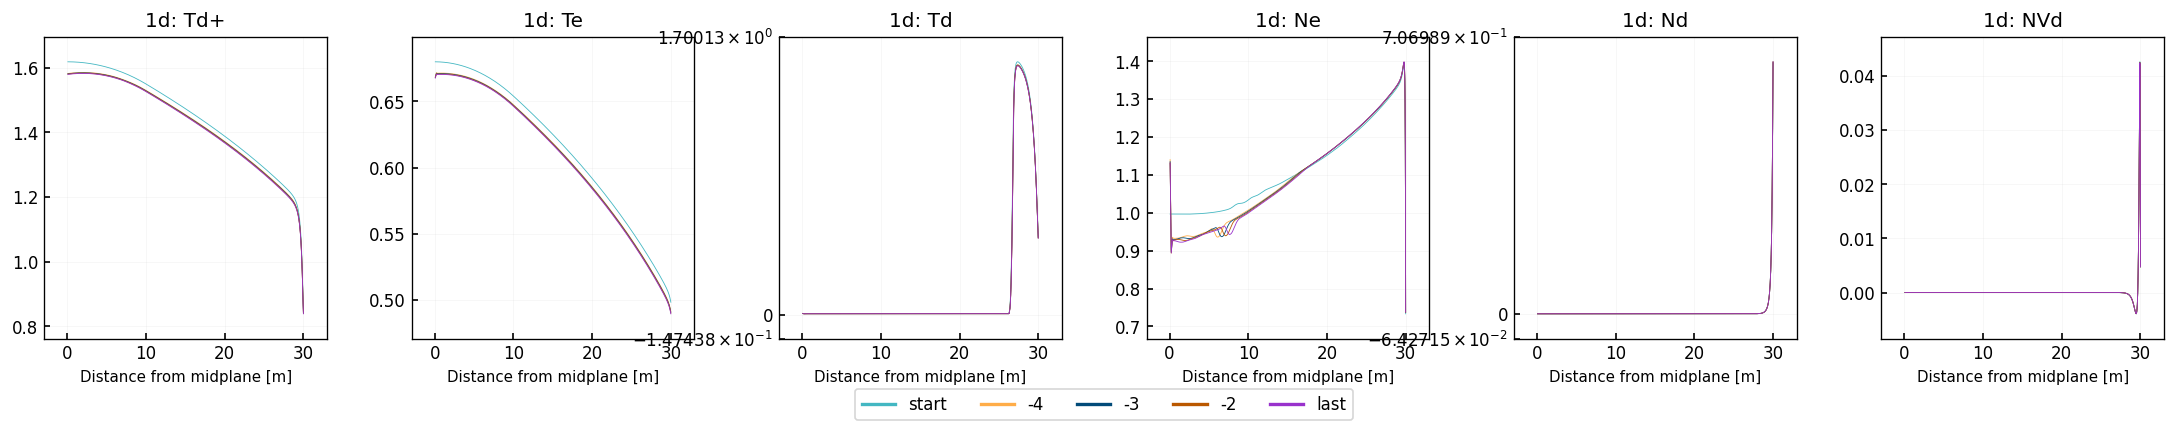

In [ ]:
case = "test"

lineplot(
    {
        "start":cs[case].ds.isel(t=0),
        "-4":cs[case].ds.isel(t=-4),
        "-3":cs[case].ds.isel(t=-3),
        "-2":cs[case].ds.isel(t=-2),
        "last":cs[case].ds.isel(t=-1),

    },
    clean_guards = True,
    params = ["Td+", "Te", "Td", "Ne", "Nd", "NVd"],
    regions = ["1d"],
    lw = 0.5,
    markersize = 0
    # xlims=(8,10.3)
)